# Building Autoencoders in Keras
    
    A Simple autoencoder based on a fully-connected layer
    A Sparse autoencoder
    A Deep fully-connected autoencoder
    A Deep convolutional autoencoder
    An Image denoising model
    A Sequence-to-sequence autoencoder
    A Variational autoencoder

In [1]:
## "Autoencoding" is a data compression algorithm where the compression and decompression functions are 
## 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human.
## Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression
## functions are implemented with neural networks.

In [2]:
## One setback is Autoencoders are lossy, i.e. they losse sm info when compressing data,
## and so the new i8mage is a little degraded

### A Simple autoencoder

In [1]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [3]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')

In [2]:
## Loading the dataset

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print (x_train.shape)
print (x_test.shape)

Using TensorFlow backend.


(60000, 784)
(10000, 784)


In [4]:
## training the model

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0705 - val_loss: 0.0405
Epoch 2/50
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0346 - val_loss: 0.0290
Epoch 3/50
60000/60000 [==============================] - 1s 13us/sample - loss: 0.0260 - val_loss: 0.0229
Epoch 4/50
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0213 - val_loss: 0.0192
Epoch 5/50
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0183 - val_loss: 0.0168
Epoch 6/50
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0162 - val_loss: 0.0150
Epoch 7/50
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0146 - val_loss: 0.0136
Epoch 8/50
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0133 - val_loss: 0.0125
Epoch 9/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0124 - val_

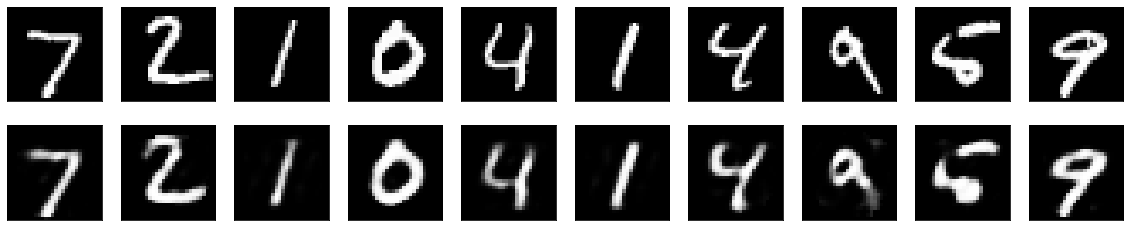

In [6]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
def plot_imgs(decoded_imgs):
    
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Adding a sparsity constraint on the encoded representations

In [11]:
## What typically happens is that the hidden layer is learning an approx. of PCA (principal component analysis).
## But another way to constrain the representations to be compact is to add a sparsity contraint on the activity
## of the hidden representations, so fewer units would "fire" at a given time.
## In Keras, this can be done by adding an activity_regularizer to our Dense layer

In [18]:
from tensorflow.keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [19]:
autoencoder.compile(optimizer='adam', loss='mse')

## training the model

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0772 - val_loss: 0.0463
Epoch 2/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0402 - val_loss: 0.0349
Epoch 3/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0322 - val_loss: 0.0292
Epoch 4/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0275 - val_loss: 0.0253
Epoch 5/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0244 - val_loss: 0.0228
Epoch 6/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0222 - val_loss: 0.0209
Epoch 7/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0206 - val_loss: 0.0196
Epoch 8/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0195 - val_loss: 0.0187
Epoch 9/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0187 - val_

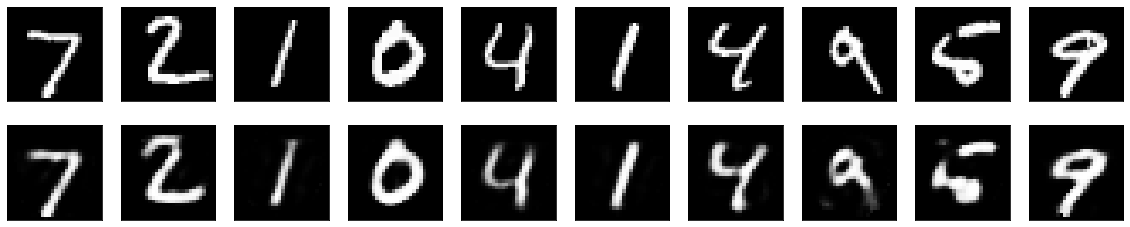

In [20]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Deep autoencoder

In [21]:
## We do not have to limit ourselves to a single layer as encoder or decoder, 
## we could instead use a stack of layers

In [22]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [24]:
## trainig n compiling

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 11s 192us/sample - loss: 0.0641 - val_loss: 0.0383
Epoch 2/100
60000/60000 [==============================] - 9s 145us/sample - loss: 0.0319 - val_loss: 0.0262
Epoch 3/100
60000/60000 [==============================] - 8s 141us/sample - loss: 0.0237 - val_loss: 0.0211
Epoch 4/100
60000/60000 [==============================] - 9s 145us/sample - loss: 0.0203 - val_loss: 0.0184
Epoch 5/100
60000/60000 [==============================] - 9s 145us/sample - loss: 0.0181 - val_loss: 0.0169
Epoch 6/100
60000/60000 [==============================] - 9s 147us/sample - loss: 0.0168 - val_loss: 0.0158
Epoch 7/100
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0158 - val_loss: 0.0150
Epoch 8/100
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0150 - val_loss: 0.0143
Epoch 9/100
60000/60000 [==============================] - 8s 137us/sample - 

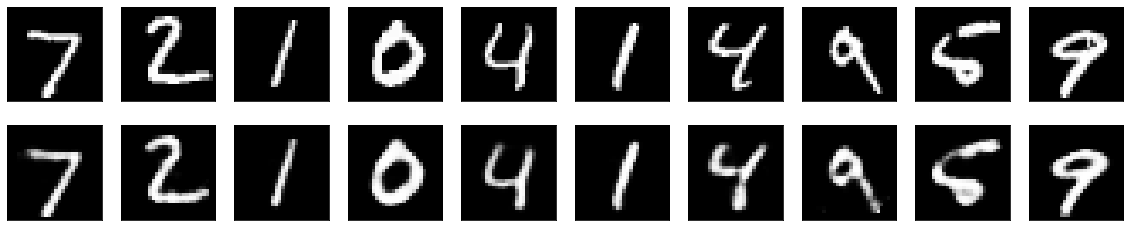

In [28]:
decoded_imgs = autoencoder.predict(x_test)

plot_imgs(decoded_imgs)

### Convolutional autoencoder

In [26]:
## Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders 
## and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders 
## --they simply perform much better.

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras import backend as K

x = Input(shape=(28, 28,1)) 

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)


# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 8)           0   

In [16]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np

nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [17]:
from tensorflow.keras.callbacks import TensorBoard

autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 41s 680us/sample - loss: 0.2393 - val_loss: 0.1482
Epoch 2/10
60000/60000 [==============================] - 40s 669us/sample - loss: 0.1375 - val_loss: 0.1282
Epoch 3/10
60000/60000 [==============================] - 41s 684us/sample - loss: 0.1249 - val_loss: 0.1202
Epoch 4/10
60000/60000 [==============================] - 42s 698us/sample - loss: 0.1187 - val_loss: 0.1153
Epoch 5/10
60000/60000 [==============================] - 41s 678us/sample - loss: 0.1147 - val_loss: 0.1120
Epoch 6/10
60000/60000 [==============================] - 39s 656us/sample - loss: 0.1118 - val_loss: 0.1092
Epoch 7/10
60000/60000 [==============================] - 40s 675us/sample - loss: 0.1096 - val_loss: 0.1076
Epoch 8/10
60000/60000 [==============================] - 44s 730us/sample - loss: 0.1080 - val_loss: 0.1060
Epoch 9/10
60000/60000 [==============================] - 43s 717us/sample - l

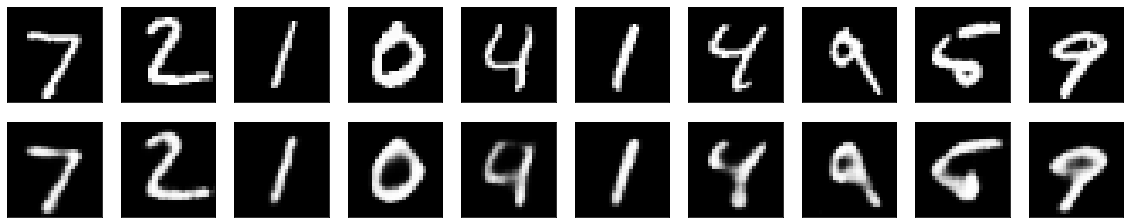

In [18]:
## Predicting the results

decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Image Denoising

In [19]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

## adding noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

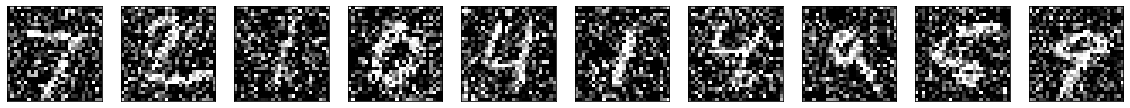

In [20]:
## the noisy images look like:

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [21]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [22]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.1666 - val_loss: 0.1161
Epoch 2/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.1131 - val_loss: 0.1087
Epoch 3/10
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.1079 - val_loss: 0.1050
Epoch 4/10
60000/60000 [==============================] - 88s 1ms/sample - loss: 0.1047 - val_loss: 0.1025
Epoch 5/10
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.1025 - val_loss: 0.1008
Epoch 6/10
60000/60000 [==============================] - 88s 1ms/sample - loss: 0.1011 - val_loss: 0.0997
Epoch 7/10
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.1000 - val_loss: 0.0992
Epoch 8/10
60000/60000 [==============================] - 85s 1ms/sample - loss: 0.0993 - val_loss: 0.0985
Epoch 9/10
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.0987 - val_

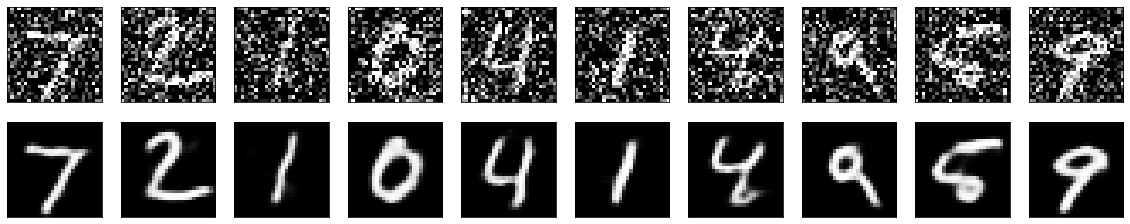

In [26]:
## Predicting the results

decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Variational autoencoder (VAE)

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

In [35]:
## encoder model

intermediate_dim = 512
batch_size = 128
latent_dim = 2

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [36]:
from tensorflow.keras.layers import Lambda

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [37]:
## mapping the sample latent points

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [38]:
## so far we have these 3 models

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [39]:
## We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, 
## and the KL divergence regularization term.

def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

NameError: name 'objectives' is not defined

In [ ]:
## training the model

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
## since VAE is a generative model, wwe can use it to generate new digits

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()